cuda

Wave Power:9.387900354340672e-05
Radar Power:0.00010000099427998066


100%|██████████| 100/100 [00:00<00:00, 541.34it/s]


LFM (with abs)==============================
Mean value->355.8470458984375, 	 Variance->0.3874136805534363
Mean value->2.372313701926032e-06, 	 Variance->1.721838318138946e-17 	 CRLB:2.3747389239441963e-17
MSE: 0.4069354236125946


100%|██████████| 100/100 [00:00<00:00, 540.14it/s]


LFM (with real)==============================
Mean value->355.92803955078125, 	 Variance->0.12912030518054962
Mean value->2.3728534870315343e-06, 	 Variance->5.738696194123413e-18 	 CRLB:5.936847309860491e-18
MSE: 0.1330074518918991


100%|██████████| 100/100 [00:00<00:00, 518.81it/s]


Wave==============================
Mean value->355.9625244140625, 	 Variance->0.004919020924717188
Mean value->2.373083589191083e-06, 	 Variance->2.18594729479961e-19
MSE: 0.006274250335991383
tensor(6.0701e-07, device='cuda:0')
tensor(5.4501e-07, device='cuda:0')
tensor(577355.9375, device='cuda:0')
tensor(5.9366e-09, device='cuda:0')


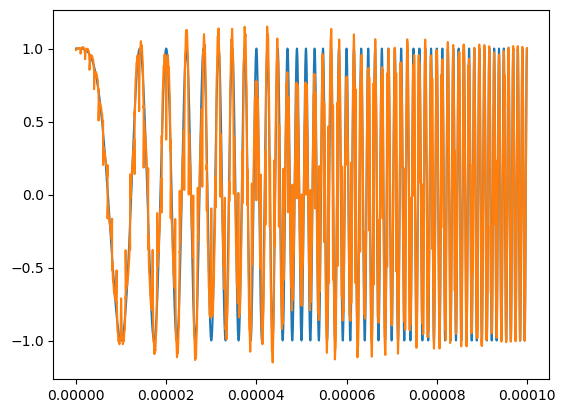

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from deap.tools import Statistics
from pulses import RadarPulseGenerator, CommPulseGenerator, generate_walsh_matrix
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

t = torch.linspace(0, 1e-4, int(1e5), device=device)
dt = t[1] - t[0]

# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5         # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval
A = 0.8
MN = 100
distance = 356
N0 = 10
comm_pulse_kind = 'OFDMA'
radar_pulse_kind = 'LFM'

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadarPulses = RadarPulseGenerator(t, T=T, device=device)
g_funcs = lambda l, k: myCommPulses.OFDMA_pulse(l, k-1)
radar_pulse = myRadarPulses.LFM_pulse(B)

g_vec = torch.zeros((L*K, len(t)), device=device, dtype=torch.complex64)
for l in range(L):
    for k in range(K):
        g_vec[l*K + k, :] = g_funcs(l, k+1)

Q = torch.matmul(g_vec, g_vec.conj().T)*(t[1]-t[0])
R = radar_pulse.repeat(K*L, 1)
G = torch.diag(torch.matmul(R, g_vec.conj().T))*(t[1]-t[0])
c_opt = torch.matmul(G, torch.inverse(Q))
s_opt = torch.sum(c_opt[:, torch.newaxis].repeat(1, len(t)) * g_vec, dim=0)

plt.figure()
plt.plot(t.cpu(), radar_pulse.cpu().real)
plt.plot(t.cpu(), s_opt.cpu().real)

print()
print(f"Wave Power:{torch.sum(torch.abs(s_opt)**2)*dt}")
print(f"Radar Power:{torch.sum(torch.abs(radar_pulse)**2)*dt}")

dis, ta = myRadarPulses.montecarlo_estimation_with_abs(radar_pulse, N0, distance, np.sqrt(A), 3e8, MN)
print("LFM (with abs)" + "="*30)
print(f'Mean value->{torch.mean(dis)}, \t Variance->{torch.var(dis)}')
print(f'Mean value->{torch.mean(ta)}, \t Variance->{torch.var(ta)} \t CRLB:{myRadarPulses.LFM_delayCRLB_with_abs(B, T, N0, A)}')
print(f"MSE: {torch.mean(torch.abs(dis - distance)**2)}")

dis, ta = myRadarPulses.montecarlo_estimation_with_real(radar_pulse, N0, distance, np.sqrt(A), 3e8, MN)
print("LFM (with real)" + "="*30)
print(f'Mean value->{torch.mean(dis)}, \t Variance->{torch.var(dis)}')
print(f'Mean value->{torch.mean(ta)}, \t Variance->{torch.var(ta)} \t CRLB:{myRadarPulses.LFM_delayCRLB_with_real(B, T, N0, A)}')
print(f"MSE: {torch.mean(torch.abs(dis - distance)**2)}")

dis, ta = myRadarPulses.montecarlo_estimation_with_real(s_opt, N0, distance, np.sqrt(A), 3e8, MN)
print("Wave" + "="*30)
print(f'Mean value->{torch.mean(dis)}, \t Variance->{torch.var(dis)}')
print(f'Mean value->{torch.mean(ta)}, \t Variance->{torch.var(ta)}')
print(f"MSE: {torch.mean(torch.abs(dis - distance)**2)}")

plt.figure()
xcr_LFM = torch.abs(myRadarPulses.cross_correlation(radar_pulse, radar_pulse))
xcr_mySig = torch.abs(myRadarPulses.cross_correlation(s_opt, s_opt))

print(torch.argmin(torch.abs(xcr_LFM - xcr_LFM[torch.argmax(xcr_LFM)]/2)**2)*dt)
print(torch.argmin(torch.abs(xcr_mySig - xcr_mySig[torch.argmax(xcr_mySig)]/2)**2)*dt)
# print(xcr_LFM[torch.argmax(xcr_LFM)])
# print(xcr_mySig[torch.argmax(xcr_mySig)])

Beff_1 = myRadarPulses.compute_Beff(radar_pulse)
Beff_2 = myRadarPulses.compute_Beff(s_opt)
Teff_1 = myRadarPulses.compute_Teff(radar_pulse)
Teff_2 = myRadarPulses.compute_Teff(s_opt)
sig_energy1 = torch.sum(torch.abs(radar_pulse)**2)*dt
sig_energy2 = torch.sum(torch.abs(s_opt)**2)*dt
print(Beff_1)
print(myRadarPulses.crlb_delay(A**2 * torch.sum(torch.abs(radar_pulse)**2)*dt / N0, Beff_1) * sig_energy1**2)

In [ ]:
ambiguity = myRadarPulses.fast_ambiguity(radar_pulse, radar_pulse)

# Magnitude squared (normalized)
ambiguity_mag = torch.abs(ambiguity)**2
# ambiguity_mag = ambiguity_mag / torch.max(ambiguity_mag)

# Plot
plt.figure(figsize=(10, 6))
plt.imshow(ambiguity_mag.cpu().numpy(),
           aspect='auto', cmap='viridis')
plt.xlabel('Doppler Shift (kHz)')
plt.ylabel('Delay (ms)')
plt.title('Ambiguity Function of LFM Pulse (Fast Method)')
plt.colorbar(label='Normalized Magnitude')
plt.tight_layout()
plt.show()

ambiguity_mag[torch.argmax(ambiguity_mag)]